# Introduction
## Using Google Search Volume and News Sentiment to Predict Natural Gas Prices with LSTMs
by Quinn Murphey, Adrian Ramos, and Gabriel Soliz

In [125]:
import os
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import tensorflow as tf
import math
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Data Fetch Stage

## US EIA NYMEX Dataset
TODO EXPLAIN DATASET

In [126]:
# Read csvs to dataframes
nymex_spot_df = pd.read_csv("data/US_EIA_NYMEX_spot.csv")
nymex_futures_df = pd.read_csv("data/US_EIA_NYMEX_futures.csv")

# Turn Date column into a datetime object rather than string
nymex_spot_df["Date"] = nymex_spot_df["Date"].map(lambda str : datetime.strptime(str, "%b %d, %Y"))
nymex_futures_df["Date"] = nymex_futures_df["Date"].map(lambda str : datetime.strptime(str, "%b %d, %Y"))

# Trim to Jan 2013 - Jun 2019
nymex_spot_df = nymex_spot_df[(nymex_spot_df["Date"] >= datetime(year=2013, month=1, day=1)) & (nymex_spot_df["Date"] <= datetime(year=2019, month=6, day=30))]
nymex_futures_df = nymex_futures_df[(nymex_futures_df["Date"] >= datetime(year=2013, month=1, day=1)) & (nymex_futures_df["Date"] <= datetime(year=2019, month=6, day=30))]

# Reset index
nymex_spot_df = nymex_spot_df.set_index("Date")
nymex_futures_df = nymex_futures_df.set_index("Date")

# Rename Columns
nymex_spot_df    = nymex_spot_df.rename(columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'Spot Price'})
nymex_futures_df = nymex_futures_df.rename(columns={'Natural Gas Futures Contract 1 (Dollars per Million Btu)':'Futures 1 Price','Natural Gas Futures Contract 2 (Dollars per Million Btu)':'Futures 2 Price','Natural Gas Futures Contract 3 (Dollars per Million Btu)':'Futures 3 Price','Natural Gas Futures Contract 4 (Dollars per Million Btu)':'Futures 4 Price'})

In [127]:
nymex_spot_df

,Spot Price
Date,
2013-01-02,3.30
2013-01-03,3.19
2013-01-04,3.20
2013-01-07,3.30
2013-01-08,3.21
...,...
2019-06-24,2.31
2019-06-25,2.31
2019-06-26,2.34


In [128]:
nymex_futures_df

,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,
2013-01-02,3.233,3.255,3.294,3.349
2013-01-03,3.198,3.214,3.250,3.306
2013-01-04,3.287,3.303,3.337,3.393
2013-01-07,3.266,3.281,3.318,3.374
2013-01-08,3.218,3.234,3.275,3.330
...,...,...,...,...
2019-06-24,2.303,2.284,2.256,2.291
2019-06-25,2.308,2.286,2.260,2.294
2019-06-26,2.291,2.268,2.244,2.275


## Google Trends Dataset

### PyTrends Scraper

In [144]:
import pytrends
from pytrends.request import TrendReq
import time
pytrend = TrendReq()

def get_daily_trends_as_df(keywords, categories, timeframe, countries, search_type):
    # Get pytrend suggestions and store them in exact_keywords
    keywords_codes = [pytrend.suggestions(keyword=i)[0] for i in keywords] 
    df_CODES= pd.DataFrame(keywords_codes)
    exact_keywords = df_CODES['mid'].to_list()

    # Store keywords alongside their respective categories
    individual_exact_keyword = list(zip(*[iter(exact_keywords)]*1, categories))
    individual_exact_keyword = [list(x) for x in individual_exact_keyword]

    # Split timeframe into 6 month chunks
    timeframe_start, timeframe_end = timeframe.split(" ")
    start_date = date.fromisoformat(timeframe_start)
    end_date = date.fromisoformat(timeframe_end)
    dates = []
    while start_date < end_date:
        dates.append(start_date)
        start_date = start_date + relativedelta(months=6)
    dates.append(end_date + relativedelta(days=1))

    # Compute number of fetches required
    max_fetches = len(countries) * len(keywords) * (len(dates) - 1)
    curr_fetches = 0

    trend_dict = {}
    for country in countries:
        for keyword, category in individual_exact_keyword:
            trend_dict[keyword] = pd.DataFrame()
            for i in range(len(dates)-1):
                pytrend.build_payload(kw_list=[keyword], 
                                    timeframe = dates[i].isoformat() + " " + (dates[i + 1] - relativedelta(days=1)).isoformat(), 
                                    geo = country, 
                                    cat=category,
                                    gprop=search_type)
                curr_fetches += 1
                print("[" + "=" * math.floor(20 * curr_fetches / max_fetches - 1) +  ">" * min(math.floor(20 * curr_fetches / max_fetches), 1) + " " * (20 - math.floor(20 * curr_fetches / max_fetches)) + "] ",end='')
                print(f"{math.floor(10000 * curr_fetches / max_fetches)/100}% Complete!", end='\r')
                time.sleep(15) # sleep to prevent google shutting us down
                trend_dict[keyword] = pd.concat([trend_dict[keyword], pytrend.interest_over_time()], axis=0)
            i+=1
    df_trends = pd.concat(trend_dict, axis=1)

    df_trends.columns = df_trends.columns.droplevel(0) #drop outside header
    df_trends = df_trends.drop('isPartial', axis = 1) #drop "isPartial"
    df_trends.reset_index(level=0,inplace=True) #reset_index
    df_trends.columns = ['Date'] + keywords
    df_trends["Date"] = df_trends["Date"].map(lambda str : datetime.strptime(str, "%Y-%m-%d"))
    df_trends = df_trends.set_index("Date")

    return df_trends

In [153]:
KEYWORDS            = ["Natural Gas","Oil","Coal","Nuclear Power","Wind Power","Hydroelectric","Solar Power","Gold","Silver","Platinum","Copper","Biofuel","Recession","CPI"]
KEYWORDS_CATEGORIES = [904,          904,  904,   0,               0,          0,               0,           904,   904,     904,       904,     0,        0,          0]
TIMEFRAME='2013-01-01 2019-06-30' # Jan 2013 - June 2019
COUNTRIES=["US"] # ISO country code
SEARCH_TYPE='' #default is 'web searches',others include 'images','news','youtube','froogle' (google shopping)

try:
    google_trends_df = pd.read_csv("data/google_trends_dataset.csv")
    google_trends_df["Date"] = google_trends_df["Date"].map(lambda str : datetime.strptime(str, "%Y-%m-%d"))
    google_trends_df = google_trends_df.set_index("Date")
except:
    google_trends_df = get_daily_trends_as_df(KEYWORDS, KEYWORDS_CATEGORIES, TIMEFRAME, COUNTRIES, SEARCH_TYPE)
    google_trends_df.to_csv("data/google_trends_dataset.csv")

google_trends_df

,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,
2013-01-01,8,37,0,18,43,15,40,18,35,33,27,34,53,16
2013-01-02,62,95,0,20,60,28,52,23,50,31,72,47,49,55
2013-01-03,54,81,0,23,52,18,56,23,45,15,42,55,41,45
2013-01-04,68,78,27,19,54,23,51,23,43,100,58,37,51,45
2013-01-05,7,68,0,15,33,11,46,23,34,36,54,15,25,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,25,44,0,41,20,6,67,87,75,43,79,31,35,59
2019-06-27,28,56,0,35,30,23,66,77,74,68,68,22,44,60
2019-06-28,30,55,0,38,20,10,66,79,67,79,73,31,38,50


## Financial Times Scraper

# Data Preprocessing Stage

## NYMEX

### Join dataframes (by date)

In [131]:
nymex_df = pd.concat([nymex_spot_df, nymex_futures_df],axis=1)
nymex_df

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2013-01-02,3.30,3.233,3.255,3.294,3.349
2013-01-03,3.19,3.198,3.214,3.250,3.306
2013-01-04,3.20,3.287,3.303,3.337,3.393
2013-01-07,3.30,3.266,3.281,3.318,3.374
2013-01-08,3.21,3.218,3.234,3.275,3.330
...,...,...,...,...,...
2019-06-24,2.31,2.303,2.284,2.256,2.291
2019-06-25,2.31,2.308,2.286,2.260,2.294
2019-06-26,2.34,2.291,2.268,2.244,2.275


However, there are some NaN values due to the dates covered differing

In [132]:
nymex_df.isna().sum()

Spot Price         19
Futures 1 Price    33
Futures 2 Price    33
Futures 3 Price    33
Futures 4 Price    33
dtype: int64

### Fill spot price voids 
Interpolate all voids linearly (by column)

In [133]:
nymex_df = nymex_df.interpolate(method='linear')
nymex_df.isna().sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

### Normalize columns
First log all values: $x' = \log{x}$, then normalize: $x' = (x - \mu)/\sigma$

Check for negative values

In [134]:
(nymex_df <= 0).sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

Log each value

In [135]:
nymex_df_normalized = np.log(nymex_df)
nymex_df_normalized

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2013-01-02,1.193922,1.173410,1.180192,1.192103,1.208662
2013-01-03,1.160021,1.162526,1.167516,1.178655,1.195739
2013-01-04,1.163151,1.189975,1.194831,1.205072,1.221714
2013-01-07,1.193922,1.183566,1.188148,1.199362,1.216099
2013-01-08,1.166271,1.168760,1.173720,1.186318,1.202972
...,...,...,...,...,...
2019-06-24,0.837248,0.834213,0.825928,0.813593,0.828988
2019-06-25,0.837248,0.836381,0.826804,0.815365,0.830297
2019-06-26,0.850151,0.828988,0.818898,0.808260,0.821980


Normalize each row

In [136]:
for column in nymex_df_normalized.columns:
    nymex_df_normalized[column] = (nymex_df_normalized[column] - nymex_df_normalized[column].mean()) / nymex_df_normalized[column].std()

nymex_df_normalized

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2013-01-02,0.261039,0.207240,0.192458,0.204400,0.262528
2013-01-03,0.120823,0.158479,0.132526,0.137972,0.195724
2013-01-04,0.133768,0.281445,0.261671,0.268467,0.330004
2013-01-07,0.261039,0.252733,0.230074,0.240261,0.300975
2013-01-08,0.146673,0.186407,0.161856,0.175825,0.233116
...,...,...,...,...,...
2019-06-24,-1.214161,-1.312261,-1.482512,-1.665348,-1.700200
2019-06-25,-1.214161,-1.302546,-1.478373,-1.656598,-1.693435
2019-06-26,-1.160793,-1.335664,-1.515749,-1.691694,-1.736430


## Google Trends

### Normalize Columns 
$x' = (x- \mu)/\sigma$

In [155]:
google_trends_df_normalized = google_trends_df.copy()

for column in google_trends_df_normalized.columns:
    google_trends_df_normalized[column] = (google_trends_df_normalized[column] - google_trends_df_normalized[column].mean()) / google_trends_df_normalized[column].std()

google_trends_df_normalized

,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,
2013-01-01,-1.183636,-0.692835,-0.636261,-1.621756,-0.478050,-1.016930,-1.468401,-1.850949,-1.264325,-0.050772,-1.067542,-0.327359,0.381374,-1.564727
2013-01-02,1.505144,2.434172,-0.636261,-1.516948,0.416303,-0.498769,-0.733478,-1.592328,-0.354293,-0.160906,1.467259,0.301774,0.168334,0.270359
2013-01-03,1.106806,1.679377,-0.636261,-1.359737,-0.004569,-0.897354,-0.488503,-1.592328,-0.657637,-1.041976,-0.222609,0.688932,-0.257745,-0.200176
2013-01-04,1.803897,1.517635,0.560576,-1.569352,0.100649,-0.698062,-0.794721,-1.592328,-0.778975,3.638710,0.678654,-0.182174,0.274854,-0.200176
2013-01-05,-1.233428,0.978496,-0.636261,-1.778967,-1.004140,-1.176364,-1.100940,-1.592328,-1.324994,0.114429,0.453339,-1.246860,-1.109902,-1.282406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,-0.337168,-0.315437,-0.636261,-0.416469,-1.688057,-1.375656,0.185177,1.718018,1.162426,0.499897,1.861562,-0.472543,-0.577304,0.458573
2019-06-27,-0.187791,0.331530,-0.636261,-0.730891,-1.161967,-0.698062,0.123933,1.200777,1.101757,1.876569,1.241944,-0.908097,-0.097965,0.505627
2019-06-28,-0.088207,0.277616,-0.636261,-0.573680,-1.688057,-1.216222,0.123933,1.304225,0.677076,2.482305,1.523588,-0.472543,-0.417524,0.035092


# Data Visualization

We will create a `plot` function that will be able to plot our data with, or without label and with or without predictions

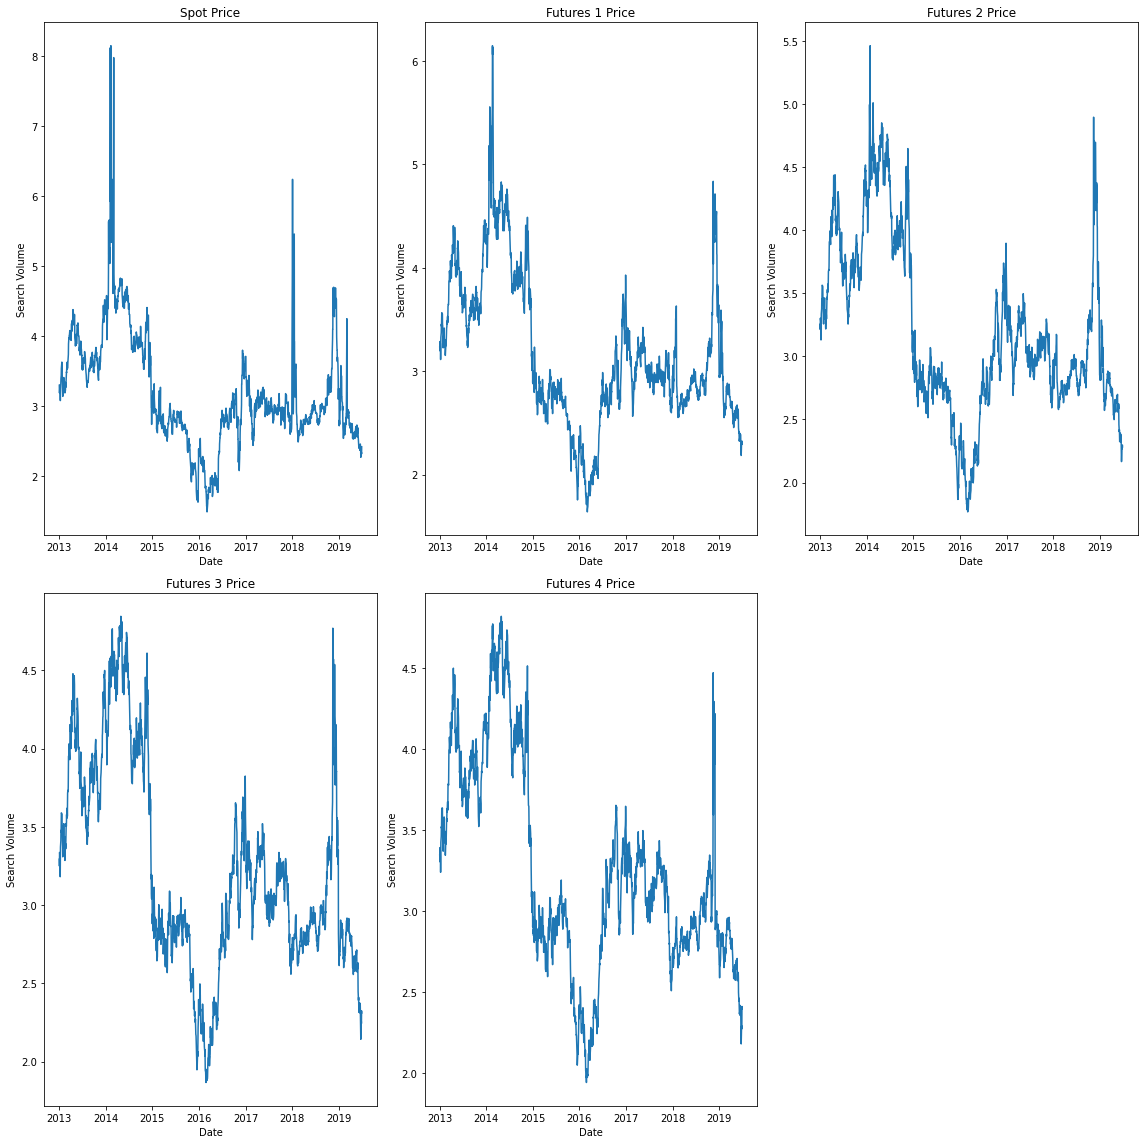

In [197]:
def plot_seperate(data, input_width=0, label_width=0, predictions=None, density=1):
    """
    data: of the form of a dataframe, indexed by a datetime object, each column being a seperate series to be plotted
    input_width: input width of time series window
    label_width: label width of time series window
    predictions: of the form of a dataframe, indexed by a datetime object, each column being a seperate series to be plotted (should match up with data column names)
    density: average every 'density' number of entries to end up plotting 1/density as many entries
    """
    # Create a 12x12 figure
    fig = plt.figure(figsize=(16,16))

    # Divide the fig into N subplots where N is the number of columns in data
    ncols=math.ceil(math.sqrt(len(data.columns)))
    nrows=math.ceil( len(data.columns) / ncols)
    i = 1
    for column in data.columns:
        ax = plt.subplot(nrows,ncols,i)
        i+=1

        ax.set_title(column)

        plt.ylabel('Search Volume')
        plt.xlabel('Date')

        plt.plot(data.index,data[column])

    plt.tight_layout()
    plt.show()


plot_seperate(nymex_df)

# Model Training Stage

# Model Testing Stage